# **IMPORTING DATA FROM GBQ - IMPORTING LIBRARIES**

In [ ]:
from google.colab import auth
auth.authenticate_user()


In [ ]:
import os
os.environ["GOOGLE_CLOUD_PROJECT"] = "neonauts"


In [ ]:
from google.cloud import bigquery
client = bigquery.Client()


In [ ]:
query = """
SELECT *
FROM `neonauts.dbt_azoellner.int_transformed_neo_bank`

"""
df = client.query(query).to_dataframe()

In [ ]:
df

,user_id,birth_year,country,crypto_unlocked,plan,num_contacts,sign_up_date,age,is_standard_user,is_premium_user,...,transactions_type_card_payment,direction_inbound,direction_outbound,direction_ratio,days_since_last_transaction,avg_transactions_per_day,avg_inbound,avg_outbound,active_timeframe,active_user
0,1557,1998,IE,0,STANDARD,37,2018-02-08,20,1,0,...,250,144,562,3.903,0,1.525,0.311,1.214,462,1
1,18551,1954,IE,0,STANDARD,25,2018-12-15,64,1,0,...,120,40,121,3.025,1,1.059,0.263,0.796,151,1
2,1102,1994,GB,0,STANDARD,0,2018-01-13,24,1,0,...,401,65,509,7.831,1,1.176,0.133,1.043,487,1
3,15868,1985,PL,0,STANDARD,19,2018-11-27,33,1,0,...,34,13,43,3.308,1,0.329,0.076,0.253,169,1
4,6877,1977,GB,0,STANDARD,7,2018-06-10,41,1,0,...,189,78,214,2.744,2,0.877,0.234,0.643,338,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18525,934,1983,GB,1,STANDARD,0,2018-01-07,35,1,0,...,0,1,0,0.000,494,1.000,1.000,0.000,0,0
18526,72,1995,GB,0,STANDARD,0,2018-01-05,23,1,0,...,0,3,1,0.333,495,2.000,1.500,0.500,1,0
18527,727,1991,GB,0,STANDARD,0,2018-01-04,27,1,0,...,0,2,3,1.500,495,2.500,1.000,1.500,2,0
18528,1130,1987,GB,0,STANDARD,0,2018-01-04,31,1,0,...,0,3,4,1.333,495,2.333,1.000,1.333,2,0


In [ ]:
import pandas as pd

date_columns = [
    "sign_up_date",
    "first_notification",
    "last_notification",
    "first_transaction_date",
    "last_transaction_date"
]

for col in date_columns:
    df[col] = pd.to_datetime(df[col], errors='coerce')

# **MACHINE LEARNING FOR COEFFICIENTS**



In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

ML_scaler = StandardScaler().set_output(transform="pandas")
model= LogisticRegression()

X= df[[
    "avg_transactions_per_day",
    "crypto_unlocked",
    "is_standard_user",
    "is_premium_user",
    "is_metal_user",
    "average_amount_per_transaction_usd",
    "active_timeframe",
    "apple_user",
    "android_user",
    "age",
    "nb_notifications",
    "direction_ratio"
]]

y= df["active_user"]

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size= 0.2, random_state= 42)

X_train_scaled = ML_scaler.fit_transform(X_train)
X_test_scaled = ML_scaler.transform(X_test)

model.fit(X_train_scaled, y_train)


LogisticRegression()

In [ ]:
y_pred = model.predict(X_test_scaled)
from sklearn.metrics import accuracy_score,recall_score,roc_auc_score

print("Accuracy (Test):", accuracy_score(y_test, y_pred))
print("Recall (Test):", recall_score(y_test, y_pred))


Accuracy (Test): 0.7528332433890987
Recall (Test): 0.7955699123211813


In [ ]:
coefficients = model.coef_[0]
columns = X.columns

df_coefficients = pd.DataFrame({
    'Feature': columns,
    'Coefficient': coefficients
})

df_coefficients = df_coefficients.sort_values(by='Coefficient', ascending=False).reset_index(drop=True)

df_coefficients

,Feature,Coefficient
0,active_timeframe,1.420400
1,avg_transactions_per_day,0.440386
2,is_metal_user,0.232303
3,is_premium_user,0.126525
4,android_user,0.059710
5,direction_ratio,0.034837
6,crypto_unlocked,-0.009840
7,average_amount_per_transaction_usd,-0.029336
8,apple_user,-0.067742
9,age,-0.099378


# **WEIGHTING FOR LES**


Hybrid Approach:
Use the coefficients of the ML-Model as a foundation for the model weighting,
 but adjust based on their relevance for product strategy.

In [ ]:
from sklearn.preprocessing import MinMaxScaler
import pandas as pd

# Engagement-Features
engagement_features = [
    "avg_transactions_per_day",
    "crypto_unlocked",
    "is_standard_user",
    "is_premium_user",
    "is_metal_user",
    "average_amount_per_transaction_usd",
    "active_timeframe",
    "direction_ratio"
]

# Scaling the  Features
scaler = MinMaxScaler()
df_scaled = pd.DataFrame(scaler.fit_transform(df[engagement_features]), columns=engagement_features)

# setting the weights
weights = {
    "active_timeframe": 45,
    "avg_transactions_per_day": 20,
    "direction_ratio": 15,
    "is_metal_user": 7,
    "is_premium_user": 8,
    "is_standard_user": 0,
    "average_amount_per_transaction_usd": 3,
    "crypto_unlocked": 2
}

# calculating LES
df_scaled["LES"] = sum(
    df_scaled[feature] * weight for feature, weight in weights.items()
)

# adding the user_id
df_scaled["user_id"] = df["user_id"]
df_scaled

,avg_transactions_per_day,crypto_unlocked,is_standard_user,is_premium_user,is_metal_user,average_amount_per_transaction_usd,active_timeframe,direction_ratio,LES,user_id
0,0.072601,0.0,1.0,0.0,0.0,0.000569,0.935223,0.009271,43.677817,1557
1,0.050358,0.0,1.0,0.0,0.0,0.000858,0.305668,0.007185,14.872575,18551
2,0.055943,0.0,1.0,0.0,0.0,0.000792,0.985830,0.018601,45.762594,1102
3,0.015513,0.0,1.0,0.0,0.0,0.000582,0.342105,0.007857,15.824608,15868
4,0.041671,0.0,1.0,0.0,0.0,0.000446,0.684211,0.006518,31.721991,6877
...,...,...,...,...,...,...,...,...,...,...
18525,0.047542,1.0,1.0,0.0,0.0,0.003746,0.000000,0.000000,2.962074,934
18526,0.095274,0.0,1.0,0.0,0.0,0.002396,0.002024,0.000791,2.015634,72
18527,0.119141,0.0,1.0,0.0,0.0,0.000186,0.004049,0.003563,2.619004,727
18528,0.111169,0.0,1.0,0.0,0.0,0.003951,0.004049,0.003166,2.464922,1130


# **SEGMENT CLUSTERING WITH KMEANS**

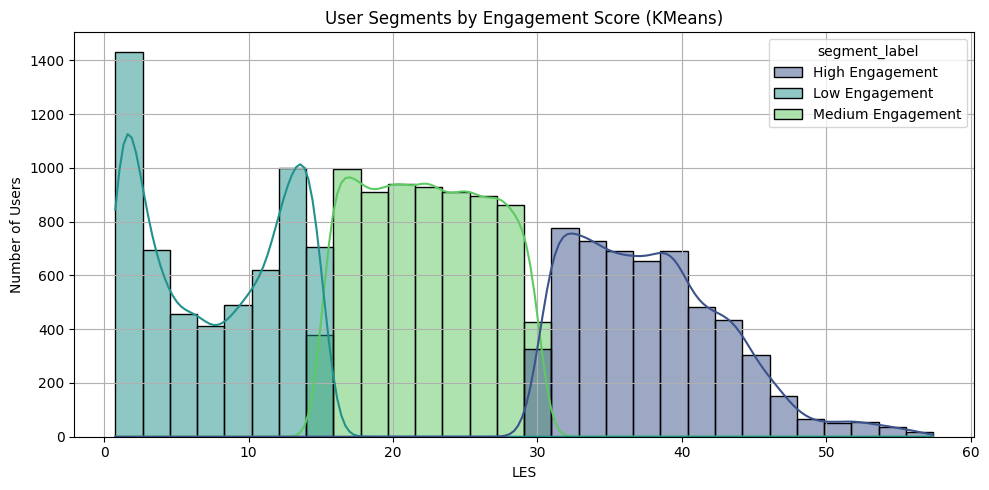

In [ ]:
import numpy as np
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Prepare the data
X = df_scaled[["LES"]].copy()
# 2. Apply KMeans with 3 clusters
kmeans = KMeans(n_clusters=3, random_state=42)
df_scaled['segment_kmeans'] = kmeans.fit_predict(X)
# 3. Sort clusters by average score for interpretability
cluster_order = df_scaled.groupby('segment_kmeans')['LES'].mean().sort_values().index
# 4. Map cluster labels to meaningful names
segment_labels = {cluster_order[0]: 'Low Engagement',
                  cluster_order[1]: 'Medium Engagement',
                  cluster_order[2]: 'High Engagement'}
df_scaled['segment_label'] = df_scaled['segment_kmeans'].map(segment_labels)
# 5. Optional: Visualize the segments
plt.figure(figsize=(10, 5))
sns.histplot(data=df_scaled, x='LES', hue='segment_label', palette='viridis', bins=30, kde=True)
plt.title('User Segments by Engagement Score (KMeans)')
plt.xlabel("LES")
plt.ylabel('Number of Users')
plt.grid(True)
plt.tight_layout()
plt.show()

# **HISTOGRAM FOR ACTIVE USERS**

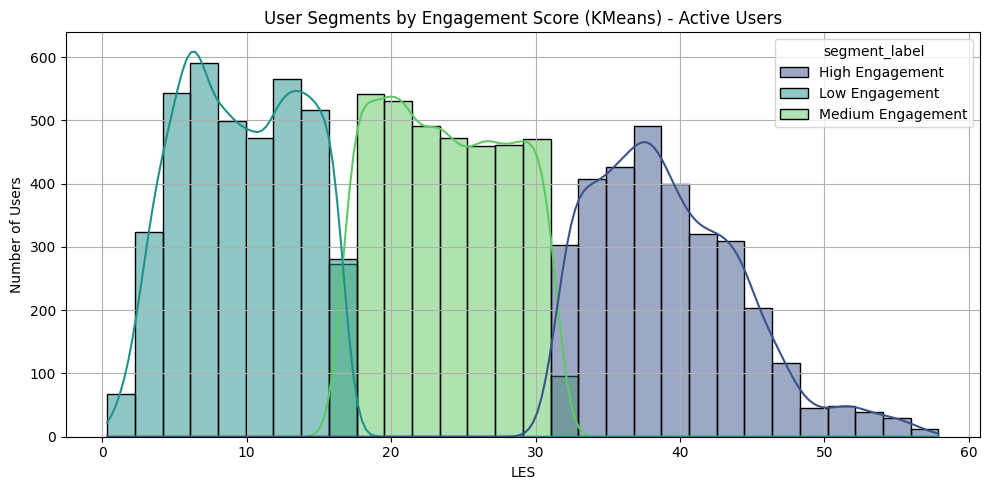

In [ ]:
# only active users
df_active = df[df["active_user"] == 1].copy()

# Engagement-Features
engagement_features = [
    "avg_transactions_per_day",
    "crypto_unlocked",
    "is_standard_user",
    "is_premium_user",
    "is_metal_user",
    "average_amount_per_transaction_usd",
    "active_timeframe",
    "direction_ratio"
]

# scaling the features
scaler = MinMaxScaler()
df_active_scaled = pd.DataFrame(scaler.fit_transform(df_active[engagement_features]), columns=engagement_features)

# setting the weights
weights = {
    "active_timeframe": 45,
    "avg_transactions_per_day": 20,
    "direction_ratio": 15,
    "is_metal_user": 7,
    "is_premium_user": 8,
    "is_standard_user": 0,
    "average_amount_per_transaction_usd": 3,
    "crypto_unlocked": 2
}

# calculating the LES
df_active_scaled["LES"] = sum(
    df_active_scaled[feature] * weight for feature, weight in weights.items()
)

# adding the user_id
df_active_scaled["user_id"] = df_active["user_id"].values

# 1. visualising

X = df_active_scaled[["LES"]].copy()
# 2. Apply KMeans with 3 clusters
kmeans = KMeans(n_clusters=3, random_state=42)
df_active_scaled['segment_kmeans'] = kmeans.fit_predict(X)
# 3. Sort clusters by average score for interpretability
cluster_order = df_active_scaled.groupby('segment_kmeans')['LES'].mean().sort_values().index
# 4. Map cluster labels to meaningful names
segment_labels = {cluster_order[0]: 'Low Engagement',
                  cluster_order[1]: 'Medium Engagement',
                  cluster_order[2]: 'High Engagement'}
df_active_scaled['segment_label'] = df_active_scaled['segment_kmeans'].map(segment_labels)
# 5. Optional: Visualize the segments
plt.figure(figsize=(10, 5))
sns.histplot(data=df_active_scaled, x='LES', hue='segment_label', palette='viridis', bins=30, kde=True)
plt.title('User Segments by Engagement Score (KMeans) - Active Users')
plt.xlabel("LES")
plt.ylabel('Number of Users')
plt.grid(True)
plt.tight_layout()
plt.show()


# **HISTOGRAM FOR INACTIVE USERS**

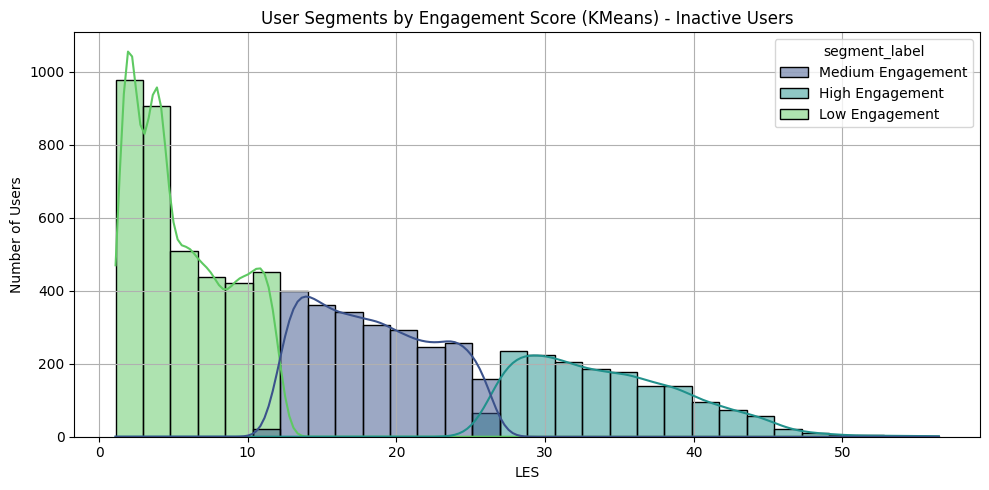

In [ ]:
# only inactive users
df_inactive = df[df["active_user"] == 0].copy()

# Engagement-Features
engagement_features = [
    "avg_transactions_per_day",
    "crypto_unlocked",
    "is_standard_user",
    "is_premium_user",
    "is_metal_user",
    "average_amount_per_transaction_usd",
    "active_timeframe",
    "direction_ratio"
]

# scaling
scaler = MinMaxScaler()
df_inactive_scaled = pd.DataFrame(scaler.fit_transform(df_inactive[engagement_features]), columns=engagement_features)

# setting the weights
weights = {
    "active_timeframe": 45,
    "avg_transactions_per_day": 20,
    "direction_ratio": 15,
    "is_metal_user": 7,
    "is_premium_user": 8,
    "is_standard_user": 0,
    "average_amount_per_transaction_usd": 3,
    "crypto_unlocked": 2
}

# calculating the LES
df_inactive_scaled["LES"] = sum(
    df_inactive_scaled[feature] * weight for feature, weight in weights.items()
)

# adding the user_id
df_inactive_scaled["user_id"] = df_inactive["user_id"].values

# 1. visualising

X = df_inactive_scaled[["LES"]].copy()
# 2. Apply KMeans with 3 clusters
kmeans = KMeans(n_clusters=3, random_state=42)
df_inactive_scaled['segment_kmeans'] = kmeans.fit_predict(X)
# 3. Sort clusters by average score for interpretability
cluster_order = df_inactive_scaled.groupby('segment_kmeans')['LES'].mean().sort_values().index
# 4. Map cluster labels to meaningful names
segment_labels = {cluster_order[0]: 'Low Engagement',
                  cluster_order[1]: 'Medium Engagement',
                  cluster_order[2]: 'High Engagement'}
df_inactive_scaled['segment_label'] = df_inactive_scaled['segment_kmeans'].map(segment_labels)
# 5. Optional: Visualize the segments
plt.figure(figsize=(10, 5))
sns.histplot(data=df_inactive_scaled, x='LES', hue='segment_label', palette='viridis', bins=30, kde=True)
plt.title('User Segments by Engagement Score (KMeans) - Inactive Users')
plt.xlabel("LES")
plt.ylabel('Number of Users')
plt.grid(True)
plt.tight_layout()
plt.show()


# **CREATING THE MART TABLE**

In [ ]:
df_LES_segment = df_scaled[["user_id", "LES", "segment_label"]]
df_scaled["user_id"] = df_scaled["user_id"].astype(int)
df["user_id"] = df["user_id"].astype(int)

mart_user_LES_Neo_Bank = df_scaled[["user_id", "LES", "segment_label"]].merge(
    df,
    on="user_id",
    how="left"
)

mart_user_LES_Neo_Bank

,user_id,LES,segment_label,birth_year,country,crypto_unlocked,plan,num_contacts,sign_up_date,age,...,transactions_type_card_payment,direction_inbound,direction_outbound,direction_ratio,days_since_last_transaction,avg_transactions_per_day,avg_inbound,avg_outbound,active_timeframe,active_user
0,1557,43.677817,High Engagement,1998,IE,0,STANDARD,37,2018-02-08,20,...,250,144,562,3.903,0,1.525,0.311,1.214,462,1
1,18551,14.872575,Low Engagement,1954,IE,0,STANDARD,25,2018-12-15,64,...,120,40,121,3.025,1,1.059,0.263,0.796,151,1
2,1102,45.762594,High Engagement,1994,GB,0,STANDARD,0,2018-01-13,24,...,401,65,509,7.831,1,1.176,0.133,1.043,487,1
3,15868,15.824608,Medium Engagement,1985,PL,0,STANDARD,19,2018-11-27,33,...,34,13,43,3.308,1,0.329,0.076,0.253,169,1
4,6877,31.721991,High Engagement,1977,GB,0,STANDARD,7,2018-06-10,41,...,189,78,214,2.744,2,0.877,0.234,0.643,338,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18525,934,2.962074,Low Engagement,1983,GB,1,STANDARD,0,2018-01-07,35,...,0,1,0,0.000,494,1.000,1.000,0.000,0,0
18526,72,2.015634,Low Engagement,1995,GB,0,STANDARD,0,2018-01-05,23,...,0,3,1,0.333,495,2.000,1.500,0.500,1,0
18527,727,2.619004,Low Engagement,1991,GB,0,STANDARD,0,2018-01-04,27,...,0,2,3,1.500,495,2.500,1.000,1.500,2,0
18528,1130,2.464922,Low Engagement,1987,GB,0,STANDARD,0,2018-01-04,31,...,0,3,4,1.333,495,2.333,1.000,1.333,2,0


In [ ]:
# 1. extracting the same features as we had in the original ML-model
X_full_data = df[[
    "avg_transactions_per_day",
    "crypto_unlocked",
    "is_standard_user",
    "is_premium_user",
    "is_metal_user",
    "average_amount_per_transaction_usd",
    "active_timeframe",
    "apple_user",
    "android_user",
    "age",
    "nb_notifications",
    "direction_ratio"
]]

# 2. scaling with the same Scaler we used for the original ML-Model
X_full_data_scaled = ML_scaler.transform(X_full_data)

# 3. Calculating the probabilitys (0 = churn/ inactive)
probabilities = model.predict_proba(X_full_data_scaled)
churn_probability = probabilities[:, 0]

# 4. creating a DF with user ID and churn-probability
df_churn_prediction = pd.DataFrame({
    'user_id': df['user_id'],
    'churn_probability': churn_probability
})

In [ ]:
df_churn_prediction

,user_id,churn_probability
0,1557,0.039869
1,18551,0.602349
2,1102,0.032957
3,15868,0.548978
4,6877,0.219796
...,...,...
18525,934,0.886719
18526,72,0.770283
18527,727,0.712433
18528,1130,0.701226


In [ ]:
mart_user_LES_Neo_Bank['user_id'] = mart_user_LES_Neo_Bank['user_id'].astype(int)
df_churn_prediction['user_id'] = df_churn_prediction['user_id'].astype(int)

mart_user_LES_Neo_Bank = mart_user_LES_Neo_Bank.merge(
    df_churn_prediction,
    on="user_id",
    how="left"
)

In [ ]:
mart_user_LES_Neo_Bank

,user_id,LES,segment_label,birth_year,country,crypto_unlocked,plan,num_contacts,sign_up_date,age,...,direction_inbound,direction_outbound,direction_ratio,days_since_last_transaction,avg_transactions_per_day,avg_inbound,avg_outbound,active_timeframe,active_user,churn_probability
0,1557,43.677817,High Engagement,1998,IE,0,STANDARD,37,2018-02-08,20,...,144,562,3.903,0,1.525,0.311,1.214,462,1,0.039869
1,18551,14.872575,Low Engagement,1954,IE,0,STANDARD,25,2018-12-15,64,...,40,121,3.025,1,1.059,0.263,0.796,151,1,0.602349
2,1102,45.762594,High Engagement,1994,GB,0,STANDARD,0,2018-01-13,24,...,65,509,7.831,1,1.176,0.133,1.043,487,1,0.032957
3,15868,15.824608,Medium Engagement,1985,PL,0,STANDARD,19,2018-11-27,33,...,13,43,3.308,1,0.329,0.076,0.253,169,1,0.548978
4,6877,31.721991,High Engagement,1977,GB,0,STANDARD,7,2018-06-10,41,...,78,214,2.744,2,0.877,0.234,0.643,338,1,0.219796
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18525,934,2.962074,Low Engagement,1983,GB,1,STANDARD,0,2018-01-07,35,...,1,0,0.000,494,1.000,1.000,0.000,0,0,0.886719
18526,72,2.015634,Low Engagement,1995,GB,0,STANDARD,0,2018-01-05,23,...,3,1,0.333,495,2.000,1.500,0.500,1,0,0.770283
18527,727,2.619004,Low Engagement,1991,GB,0,STANDARD,0,2018-01-04,27,...,2,3,1.500,495,2.500,1.000,1.500,2,0,0.712433
18528,1130,2.464922,Low Engagement,1987,GB,0,STANDARD,0,2018-01-04,31,...,3,4,1.333,495,2.333,1.000,1.333,2,0,0.701226


# **EXPORT TO BIGQUERY**

In [ ]:

table_id = "neonauts.dbt_maxstuenzner.mart_user_LES_Neo_Bank"

job_config = bigquery.LoadJobConfig(write_disposition="WRITE_TRUNCATE")

job = client.load_table_from_dataframe(mart_user_LES_Neo_Bank, table_id, job_config=job_config)

job.result()

print("Table created successfully:", table_id)

Table created successfully: neonauts.dbt_maxstuenzner.mart_user_LES_Neo_Bank
